In [143]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as pandas_ta

tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
df = yf.download(tickers, start='2018-01-01', end='2023-01-01')
df = data.stack()
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()
df.head(3)

[*********************100%%**********************]  4 of 4 completed


Price              adj close      close       high        low       open  \
date       ticker                                                          
2018-01-02 AAPL    40.722881  43.064999  43.075001  42.314999  42.540001   
           AMZN    59.450500  59.450500  59.500000  58.525501  58.599998   
           GOOGL   53.660500  53.660500  53.799000  52.651001  52.651001   

Price                 volume  
date       ticker             
2018-01-02 AAPL    102223600  
           AMZN     53890000  
           GOOGL    31766000

In [146]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)


df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])


df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2018-01-02 AAPL     40.722881   43.064999   43.075001   42.314999   42.540001   
           AMZN     59.450500   59.450500   59.500000   58.525501   58.599998   
           GOOGL    53.660500   53.660500   53.799000   52.651001   52.651001   
           MSFT     80.228996   85.949997   86.309998   85.500000   86.129997   
2018-01-03 AAPL     40.715786   43.057499   43.637501   42.990002   43.132500   
...                       ...         ...         ...         ...         ...   
2022-12-29 MSFT    238.891769  241.009995  241.919998  235.649994  235.649994   
2022-12-30 AAPL    129.207794  129.929993  129.949997  127.430000  128.410004   
           AMZN     84.000000   84.000000   84.050003   82.470001   83.120003   
           GOOGL    88.230003   88.230003   88.300003   86.570000   86.980003   
           MSFT    237.712250  239.820007  239.960007  236.660004  238.210007   

Price                 volume  garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2018-01-02 AAPL    102223600         -0.000578        NaN       NaN       NaN   
           AMZN     53890000          0.000056        NaN       NaN       NaN   
           GOOGL    31766000          0.000093        NaN       NaN       NaN   
           MSFT     22483800         -0.001901        NaN       NaN       NaN   
2018-01-03 AAPL    118071600         -0.001173        NaN       NaN       NaN   
...                      ...               ...        ...       ...       ...   
2022-12-29 MSFT     19770700          0.000273  48.608247  5.446316  5.499967   
2022-12-30 AAPL     77034200          0.000177  39.406512  4.828486  4.923169   
           AMZN     62401200          0.000137  38.821168  4.406967  4.482947   
           GOOGL    23986300          0.000117  41.993680  4.443945  4.530384   
           MSFT     21938500          0.000094  47.825544  5.444849  5.496971   

Price               bb_high       atr      macd  dollar_volume  
date       ticker                                               
2018-01-02 AAPL         NaN       NaN       NaN    4162.839531  
           AMZN         NaN       NaN       NaN    3203.787471  
           GOOGL        NaN       NaN       NaN    1704.579429  
           MSFT         NaN       NaN       NaN    1803.852706  
2018-01-03 AAPL         NaN       NaN       NaN    4807.377996  
...                     ...       ...       ...            ...  
2022-12-29 MSFT    5.553618  0.826521 -0.673281    4723.057505  
2022-12-30 AAPL    5.017853  1.137220 -2.215902    9953.419059  
           AMZN    4.558926 -0.195595 -1.225874    5241.700800  
           GOOGL   4.616823  0.567386 -1.508860    2116.311330  
           MSFT    5.549093  0.759720 -0.687689    5215.050191  

[5036 rows x 14 columns]

In [ ]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

In [158]:
df.unstack('ticker')['dollar_volume'].resample('M').mean()

ticker,AAPL,AMZN,GOOGL,MSFT
date,,,,
2018-01-31,5155.551872,6080.681703,1789.862469,2310.328548
2018-02-28,7678.640096,10351.486816,2942.096076,3247.013702
2018-03-31,5612.936062,9467.387679,2692.128532,3103.643173
2018-04-30,5091.211694,9100.464540,2436.146907,2774.293802
2018-05-31,4934.134631,5188.481244,1810.839606,2108.461234
2018-06-30,4510.634969,6950.387347,2201.589725,2714.096867
2018-07-31,3401.924867,8337.416332,2420.356995,2688.400730
2018-08-31,6196.548290,7994.820999,1850.614897,2036.426357
2018-09-30,7574.530590,9768.810944,2240.738516,2685.359570


In [142]:
import numpy as np
import pandas_ta as pandas_ta
daily_returns = df['Close'].pct_change()
volatility = daily_returns.std() * np.sqrt(252)  # There are typically 252 trading days in a year
volatility

SyntaxError: invalid syntax (3201834439.py, line 2)

In [106]:
data.index.get_level_values('Ticker').unique().tolist()

['AAPL', 'AMZN', 'GOOGL', 'MSFT']

In [79]:
data['rsi'] = data.groupby(level=1)['Adj Close'].apply(lambda x : pta.rsi(close=x , length=20,drift=1))
data

TypeError: incompatible index of inserted column with frame index

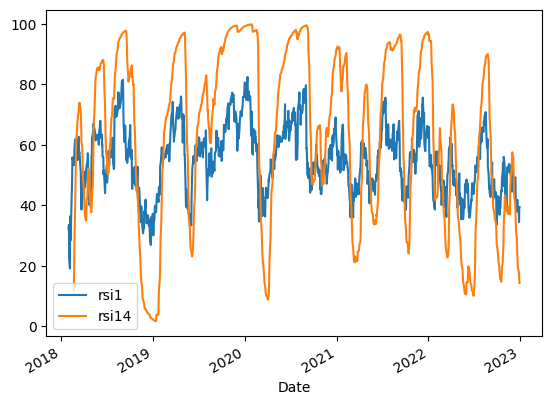

In [90]:
data['rsi'] = data.groupby(level=1)['Adj Close'].transform(lambda x : pta.rsi(close=x , length=20,drift=1))
data['rsi14'] = data.groupby(level=1)['Adj Close'].transform(lambda x : pta.rsi(close=x , length=20,drift=14))

data.xs('AAPL',level=1)['rsi'].plot(label='rsi1')
data.xs('AAPL',level=1)['rsi14'].plot(label='rsi14')
plt.legend()
plt.show()


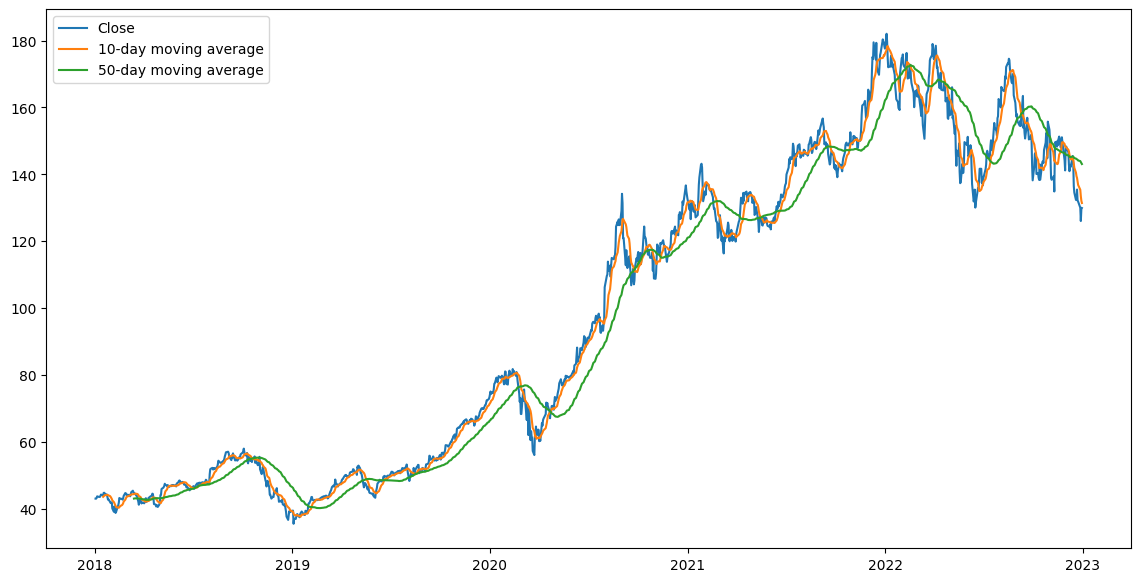

In [50]:
data['MA10'] = data['Close'].rolling(10).mean()
data['MA50'] = data['Close'].rolling(50).mean()

plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close')
plt.plot(data['MA10'], label='10-day moving average')
plt.plot(data['MA50'], label='50-day moving average')
plt.legend()
plt.show()